In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'gpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

import numpy as np
import jax.numpy as jnp
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time as t
# %matplotlib widget

from classy import Class # import classy module


## these are the main packages for background evolution and perturbation evolution
from discoeb.background import evolve_background
from discoeb.perturbations import evolve_perturbations, determine_starting_time

gpu
[cuda(id=0)]


### Setting Parameters

In [23]:

## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
Omegac  = Omegam - Omegab
w_DE_0  = -0.99
w_DE_a  = 0.0
cs2_DE  = 1.0
# Initialize neutrinos.r
num_massive_neutrinos = 1
mnu     = 0.06  #eV
Tnu     = (4/11)**(1/3) #0.71611 # Tncdm of CLASS
Neff    = 3.046 
N_nu_mass = 1
N_nu_rel = Neff - N_nu_mass * (Tnu/((4/11)**(1/3)))**4 # - (N_nu_mass * (Tnu/((4/11)**(1/3)))**4) = -1 if massive neutrino present
h       = 0.67742
A_s     = 2.1064e-09
n_s     = 0.96822
k_p     = 0.05

# modes to sample
nmodes = 2**7 #512
kmin = 1e-5
kmax = 1e+0
aexp = 1.0

# insert parameters into a dictionary
param = {}
param['Omegam']  = Omegam
param['Omegab']  = Omegab
# param['OmegaDE'] = OmegaDE
param['w_DE_0']  = w_DE_0
param['w_DE_a']  = w_DE_a
param['cs2_DE']  = cs2_DE
param['Omegak']  = 0.0
param['A_s']     = A_s
param['n_s']     = n_s
param['H0']      = 100*h
param['Tcmb']    = Tcmb
param['YHe']     = YHe
param['Neff']    = N_nu_rel
param['Nmnu']    = N_nu_mass #num_massive_neutrinos
param['mnu']     = mnu
param['k_p']     = k_p

## Running the codes

### Running DISCO-EB

In [24]:
print("N_modes -> ", nmodes)
t_bg1 = t.time()
param  = evolve_background(param=param, thermo_module='RECFAST')#, class_thermo=thermo)
t_bg2 = t.time()
print('Background computation time -> ', t_bg2 - t_bg1)
# print(param['Omegamnu'], ' ', mnu / 93.14 / h ** 2)

# compute perturbation evolution
# aexp_out = jnp.array([aexp])
aexp_out = jnp.array([1e-6,aexp]) # jnp.array(np.linspace(1e-3,aexp,50))
rtol = 1e-5
atol = 1e-5
t_pt1 = t.time()
# y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
#                                   rtol=rtol, atol=rtol, max_steps = int(2**14) )
y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
                                  # pcoeff = 0.0, icoeff = 1.0, dcoeff = 0.0, factormax = 10.0, factormin = 0.5,
                                  # pcoeff = 0.25, icoeff = 0.6, factormax = 20.0, factormin = 0.3, 
                                  # lmaxg = 25, lmaxgp = 25, lmaxr = 25, lmaxnu = 25, nqmax = 5,
                                  lmaxg = 11, lmaxgp = 11, lmaxr = 11, lmaxnu = 11, nqmax = 5,
                                  max_steps=8192,
                                  rtol=rtol, atol=atol )

# y_6, kmodes_6 = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
#                                   # pcoeff = 0.0, icoeff = 1.0, dcoeff = 0.0, factormax = 10.0, factormin = 0.5,
#                                   # pcoeff = 0.25, icoeff = 0.6, factormax = 20.0, factormin = 0.3, 
#                                   # lmaxg = 25, lmaxgp = 25, lmaxr = 25, lmaxnu = 25, nqmax = 5,
#                                   lmaxg = 11, lmaxgp = 11, lmaxr = 11, lmaxnu = 11, nqmax = 5,
#                                   max_steps=8192,
#                                   rtol=rtol/10, atol=atol/10 ) 

# param['w_DE_0']  = -0.99
# y_w, kmodes_w = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
#                                   # pcoeff = 0.0, icoeff = 1.0, dcoeff = 0.0, factormax = 10.0, factormin = 0.5,
#                                   # pcoeff = 0.25, icoeff = 0.6, factormax = 20.0, factormin = 0.3, 
#                                   # lmaxg = 25, lmaxgp = 25, lmaxr = 25, lmaxnu = 25, nqmax = 5,
#                                   lmaxg = 11, lmaxgp = 11, lmaxr = 11, lmaxnu = 11, nqmax = 5,
#                                   max_steps=8192,
#                                   rtol=rtol, atol=atol )

t_pt2 = t.time()
print('Perturbations computation time -> ', t_pt2 - t_pt1)

N_modes ->  128
Background computation time ->  3.3865487575531006
Perturbations computation time ->  25.842316389083862


### Setting and Running CLASS

In [25]:
## CLASS setup
# create instance of the class "Class"
os.environ["OMP_NUM_THREADS"] = "8"
ks = kmodes
ks = ', '.join(str(k) for k in ks)
LambdaCDM = Class()
# pass input parameters am not gonna die 
LambdaCDM.set({
    'Omega_k':0.0,
    'Omega_b':Omegab,
    'Omega_cdm':Omegam-Omegab,
    'N_ur':N_nu_rel,
    'N_ncdm':N_nu_mass,
    'm_ncdm':mnu,
    'T_ncdm': Tnu,
    'h':h,
    'A_s':A_s,
    'n_s':n_s,
    # 'gauge':'newtonian',
    'extra_metric_transfer_functions': 'yes',
    'gauge':'synchonous',
    'reio_parametrization' : 'reio_none',
    'k_per_decade_for_pk' : 100,
    'k_per_decade_for_bao' : 100,
    # 'k_output_values': ks,
    'compute damping scale' : 'yes',
    'tol_perturbations_integration' : 1e-05,
    'tol_background_integration' : 1e-05,
    # 'hyper_flat_approximation_nu' : 7000,
    'T_cmb':Tcmb,
    'YHe':YHe,
    'output':'mPk,mTk,vTk',
    #'lensing':'no',
    'P_k_max_1/Mpc': kmax*1.1,
    'z_max_pk': 1000.0,
    # 'recombination' : 'HyRec',
    'recombination' : 'RECFAST',
    # # these are high precision reference settings
    'start_small_k_at_tau_c_over_tau_h' : 0.0004,
    'start_large_k_at_tau_h_over_tau_k' : 0.05,
    'tight_coupling_trigger_tau_c_over_tau_h' : 0.005,
    'tight_coupling_trigger_tau_c_over_tau_k' : 0.008,
    'start_sources_at_tau_c_over_tau_h' : 0.006,
    
    'l_max_g' : 11,
    'l_max_pol_g' : 11,
    'l_max_ur' : 11,
    'l_max_ncdm' : 11,
    'Omega_Lambda' : 0.,
    'w0_fld' : w_DE_0,
    'wa_fld' : w_DE_a,
    'cs2_fld' : cs2_DE,
    'use_ppf' : 'no',
    'radiation_streaming_approximation' : 3,
    'ncdm_fluid_approximation' : 3,
    'ur_fluid_approximation' : 3,
    # '_MAX_NUMBER_OF_K_FILES_' : 2**15
  })
# run class
t_c1 = t.time()
LambdaCDM.compute()
bg =   LambdaCDM.get_background()
thermo = LambdaCDM.get_thermodynamics()
pert = LambdaCDM.get_perturbations()
transf, k_class, z_class = LambdaCDM.get_transfer_and_k_and_z()
t_c2 = t.time()
print("CLASS computation time -> ", t_c2 - t_c1)

CLASS computation time ->  4.734988451004028


## Getting quantities

### Getting DISCO-EB quantities

In [26]:
eta_disco, etaprime_disco, hprime_disco, alpha_disco = y[:,:,0], y[:,:,1], y[:,:,2], y[:,:,3]
A = y[:,:,20]
h_disco = np.zeros_like(eta_disco)
for i in range(kmodes.shape[0]):
    h_disco[i,:] = A[i,:] - 6 * eta_disco[i,:] 

# eta_disco_6, etaprime_disco_6, hprime_disco_6, alpha_disco_6 = y_6[:,:,0], y_6[:,:,1], y_6[:,:,2], y_6[:,:,3]
# A_6 = y_6[:,:,20]
# h_disco_6 = np.zeros_like(eta_disco_6)
# for i in range(kmodes.shape[0]):
#     h_disco_6[i,:] = A_6[i,:] - 6 * eta_disco_6[i,:] 

# eta_disco_w, etaprime_disco_w, hprime_disco_w, alpha_disco_w = y_w[:,:,0], y_w[:,:,1], y_w[:,:,2], y_w[:,:,3]
# A_w = y_w[:,:,20]
# h_disco_w = np.zeros_like(eta_disco_w)
# for i in range(kmodes.shape[0]):
#     h_disco_w[i,:] = A_w[i,:] - 6 * eta_disco_w[i,:]

### Getting CLASS quantities

In [27]:
print(transf.keys())

dict_keys(['d_g', 'd_b', 'd_cdm', 'd_fld', 'd_ur', 'd_ncdm[0]', 'd_m', 'd_tot', 'phi', 'psi', 'h', 'h_prime', 'eta', 'eta_prime', 'H_T_Nb_prime', 'k2gamma_Nb', 't_g', 't_b', 't_fld', 't_ur', 't_ncdm[0]', 't_tot'])


In [28]:
# each is a grid (k_class, z_class)

eta_class = np.zeros((k_class.shape[0],z_class.shape[0]))
h_class = np.zeros((k_class.shape[0],z_class.shape[0]))
for i in range(eta_class.shape[0]):
    eta_class[i,:] = transf ['eta'][i,:]
    h_class[i,:]   = transf ['h']  [i,:]

# eta_class      = transf ['eta'] 
etaprime_class = transf ['eta_prime'] 
# h_class        = transf ['h'] 
hprime_class   = transf ['h_prime']

phi_class = transf ['phi']
psi_class = transf ['psi']

print(eta_class.shape)

(521, 75)


## Comparision

### Synchronous gauge potentials

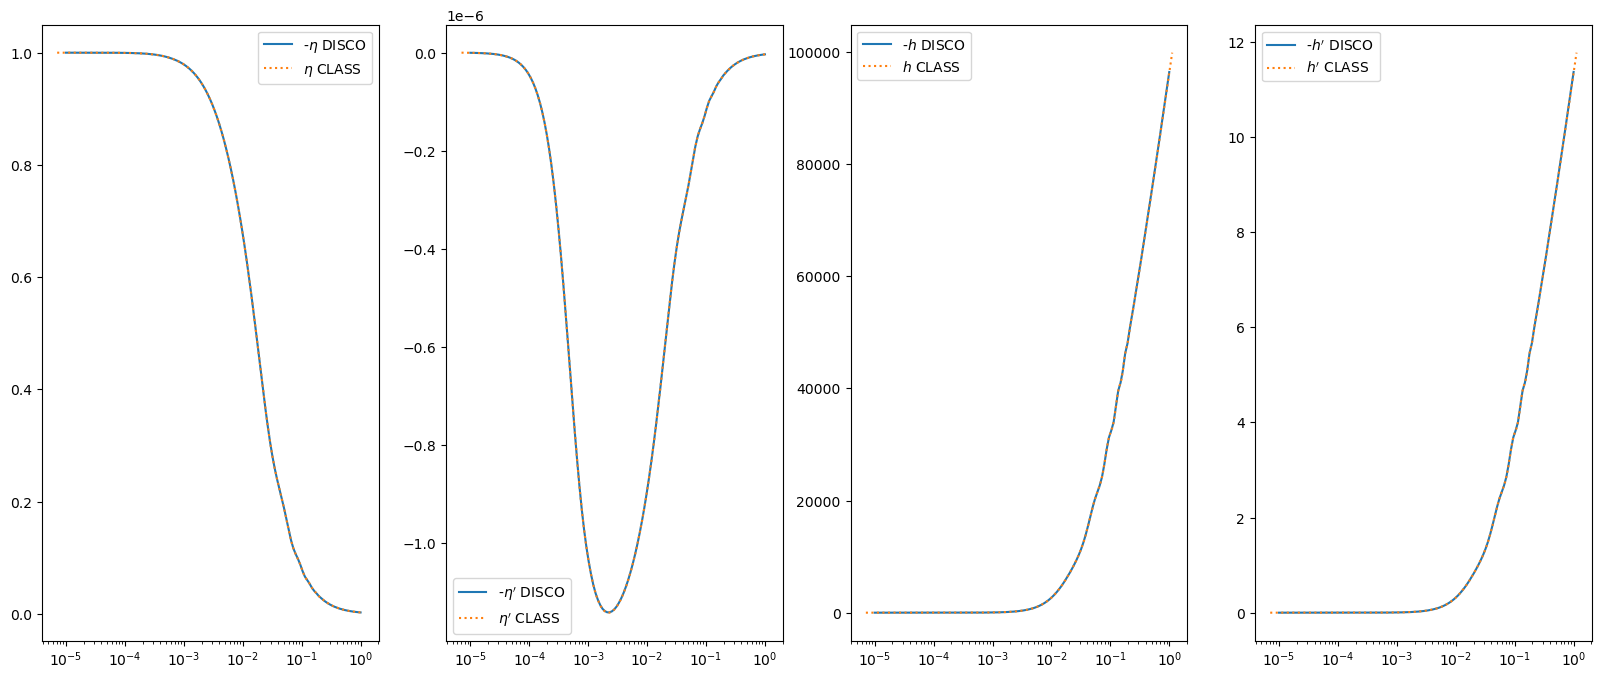

In [29]:
fig, ax = plt.subplots(1,4,figsize=(20, 8),sharex = False)

ax[0].semilogx()
ax[0].plot(kmodes, -eta_disco[:,-1], label = "-$\\eta$ DISCO")
# ax[0].plot(kmodes, -eta_disco_6[:,-1], label = "-$\\eta$ $tol = 1e-6$ DISCO", linestyle = "dashed")
# ax[0].plot(kmodes, -eta_disco_w[:,-1], label = "-$\\eta$ w DISCO", linestyle = "dotted")
ax[0].plot(k_class, eta_class[:,-1], label = "$\\eta$ CLASS",linestyle = "dotted")
ax[0].legend()

ax[1].semilogx()
ax[1].plot(kmodes, -etaprime_disco[:,-1], label = "-$\\eta'$ DISCO")
# ax[1].plot(kmodes, -etaprime_disco_6[:,-1], label = "-$\\eta'$ $tol = 1e-6$ DISCO", linestyle = "dashed")
# ax[1].plot(kmodes, -etaprime_disco_w[:,-1], label = "-$\\eta'$ w DISCO", linestyle = "dotted")
ax[1].plot(k_class, etaprime_class[:,-1], label = "$\\eta'$ CLASS", linestyle = "dotted")
ax[1].legend()


ax[2].semilogx()
ax[2].plot(kmodes, -h_disco[:,-1], label = "-$h$ DISCO")
# ax[2].plot(kmodes, -h_disco_6[:,-1], label = "-$h$ $tol = 1e-6$ DISCO", linestyle = "dashed")
# ax[2].plot(kmodes, -h_disco_w[:,-1], label = "-$h$ w DISCO", linestyle = "dotted")
ax[2].plot(k_class, h_class[:,-1], label = "$h$ CLASS", linestyle = "dotted")
ax[2].legend()

ax[3].semilogx()
ax[3].plot(kmodes, -hprime_disco[:,-1], label = "-$h'$ DISCO")
# ax[3].plot(kmodes, -hprime_disco_6[:,-1], label = "-$h'$ $tol = 1e-6$ DISCO", linestyle = "dashed")
# ax[3].plot(kmodes, -hprime_disco_w[:,-1], label = "-$h'$ w DISCO", linestyle = "dotted")
ax[3].plot(k_class, hprime_class[:,-1], label = "$h'$ CLASS", linestyle = "dotted")
ax[3].legend()


plt.show()

### Newtonian Potential

In [30]:
# computing disco phi from gauge transformation (MB95 eq. 18)
grho = y[:,:,25]
aprimeoa = np.sqrt(grho / 3.0)
phi_disco = np.zeros_like(eta_disco)# eta_disco - aprimeoa*alpha_disco
for i in range(kmodes.shape[0]):
    phi_disco[i,:] = eta_disco[i,:] - aprimeoa[i,:] * alpha_disco[i,:]

# grho_w = y_w[:,:,25]
# aprimeoa_w = np.sqrt(grho_w / 3.0)
# phi_disco_w = np.zeros_like(eta_disco_w)# eta_disco - aprimeoa*alpha_disco
# for i in range(kmodes.shape[0]):
#     phi_disco_w[i,:] = eta_disco_w[i,:] - aprimeoa_w[i,:] * alpha_disco_w[i,:]

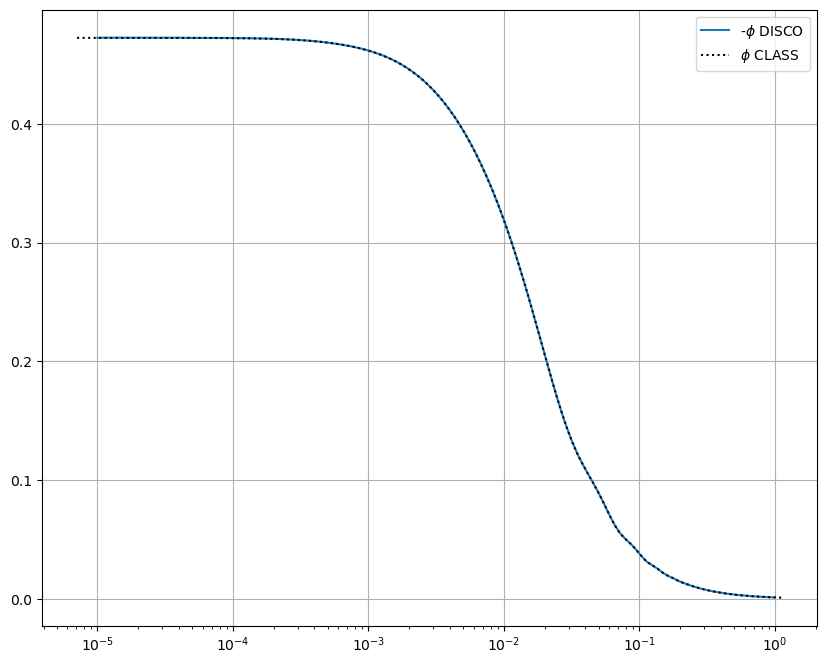

In [31]:
fig, ax = plt.subplots(1,figsize=(10, 8),sharex = True)

ax.semilogx()
ax.plot(kmodes, -phi_disco[:,-1], label = "-$\\phi$ DISCO")
# ax.plot(kmodes_w, -phi_disco_w[:,-1], label = "-$\\phi$ w DISCO", linestyle = 'dotted')
ax.plot(k_class, phi_class[:,-1], label = "$\\phi$ CLASS", color = 'k',linestyle = 'dotted')
# ax.plot(kmodes, phi_k, label = "$\\phi$ CLASS (pert)")
ax.legend()
ax.grid()

plt.show()